In [1]:
pip install pandas numpy  seaborn matplotlib scikit-learn nltk wordcloud pillow unidecode


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
nltk.download('wordnet')
from nltk import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image
from unidecode import unidecode
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package punkt to /Users/puigpi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/puigpi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/puigpi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
train = pd.read_csv("./data/Train.csv")
test = pd.read_csv("./data/Test.csv")
validation = pd.read_csv("./data/Valid.csv")

In [4]:
def Word_Cloud(df, mask_path = None):
    """
    Genera y muestra una nube de palabras a partir de un DataFrame de pandas.
    Parameters:
    - df: DataFrame de pandas que debe contener una columna llamada 'text' con el texto.
    - mask_path: Ruta de la máscara de la nube de palabras (formato de imagen).
    Returns:
    None
    """
    texto_completo = ' '.join(df['text'])

    if mask_path:
        # Cargar la máscara
        mask = np.array(Image.open(mask_path))
        
        # Crear la nube de palabras con la máscara
        wordcloud = WordCloud(width=300, height=300, random_state=21, max_font_size=110, mask=mask, background_color= 'black', contour_color= 'white', contour_width = 0.001).generate(texto_completo)
    else:
        # Crear la nube de palabras sin máscara
        wordcloud = WordCloud(width=300, height=300, random_state=21, max_font_size=110).generate(texto_completo)

    # Visualizar la nube de palabras
    '''
    plt.figure(figsize=(6, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Movie Word Cloud')
    plt.show()
    '''
    return wordcloud

In [5]:
# Visualización Nube de palabras dataSet Train original sin limpieza
ori = Word_Cloud(train, mask_path = "./data/m2.png")

In [6]:
def cleaning_starting_point(text):
    text = text.lower()
    text =  re.sub(r'@\S+', '',text)  # remove twitter handles
    text =  re.sub(r'http\S+', '',text) # remove urls
    text =  re.sub(r'pic.\S+', '',text)
    text =  re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚ']", ' ',text) # only keeps characters
    text =  re.sub(r'\s+[a-zA-ZáéíóúÁÉÍÓÚ]\s+', ' ', text+' ')  # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords])
    text= re.sub("\s[\s]+", " ",text).strip()
    text= re.sub("\s[\s]+", " ",text).strip() # remove repeated/leading/trailing spaces
    return text

def clean_text_DF(df):
    '''Limpia el texto en la columna "text" del DataFrame df, 
    convirte texto a minúsculas, se eliminan simbolos, letras sueltas, stopwords" en inglés,
    números y URLs, tokenizando las palabras,  
    Retorna un nuevo DataFrame con la columna "text" limpia.'''
    
    clean_df = df.copy(deep=True)
    
    stop_words = set(nltk.corpus.stopwords.words('english'))
    def post_processs_words(text: str) -> str:
        words = word_tokenize(text)
        # Eliminar letras suelta y palabras compuestas por 2 letras
        words = [word for word in words if len(word) > 1 and len(word) > 2]
        text = " ".join([i for i in words if i not in stop_words])
        return text
    
    clean_df["text"] = clean_df["text"].apply(lambda x: x.lower())             \
        .apply(lambda x: re.sub(r"[,.\"!@#$%^&*(){}?/;¡¿´`~:'<>+=-]", "", x))  \
        .apply(lambda x: re.sub(r'\d+', '', x))                                \
        .apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))              \
        .apply(lambda x: re.sub("\s+"," ",x))                                  \
        .apply(lambda x: unidecode(x))                                         \
        .apply(post_processs_words)          
    #print(clean_df.head())
    
    return clean_df

In [7]:
df_train = clean_text_DF(train)
df_test = clean_text_DF(test)
df_validation = clean_text_DF(validation)

In [8]:
print("df_train:\n", df_train.head(),
      '\n\ndf_test:\n',df_test.head(), 
      '\n\ndf_validation:\n',df_validation.head())

df_train:
                                                 text  label
0  grew watching loving thunderbirds mates school...      0
1  put movie dvd player sat coke chips expectatio...      0
2  people know particular time past like feel nee...      0
3  even though great interest biblical movies bor...      0
4  die hard dads army fan nothing ever change got...      1 

df_test:
                                                 text  label
0  always wrote series complete stinkfest jim bel...      0
1  watched dirsteve purcell typical mary kate ash...      0
2  movie poorly written directed fell asleep minu...      0
3  interesting thing miryang secret sunshine acto...      1
4  first read berlin meer didnt expect much thoug...      0 

df_validation:
                                                 text  label
0  years since sharon stone awarded viewers legcr...      0
1  someone needed make car payment truly awful ma...      0
2  guidelines state comment must contain minimum ...      0

In [9]:
# Uso de la funcion cleaning del starting point (verificar)
train_point = pd.DataFrame()
test_point = pd.DataFrame()
validation_point = pd.DataFrame()

train_point['text'] = train["text"].apply(cleaning_starting_point)
test_point['text'] = test["text"].apply(cleaning_starting_point)
validation_point['text'] = validation["text"].apply(cleaning_starting_point)

In [10]:
print("df_train:\n", train_point.head(),
      '\n\ndf_test:\n',test_point.head(), 
      '\n\ndf_validation:\n',validation_point.head())

df_train:
                                                 text
0  grew watching loving thunderbirds mates school...
1  put movie dvd player sat coke chips expectatio...
2  people know particular time past like feel nee...
3  even though great interest biblical movies bor...
4  im die hard dads army fan nothing ever change ... 

df_test:
                                                 text
0  always wrote series complete stink fest jim be...
1  st watched dir steve purcell ty mary kate ashl...
2  movie poorly written directed fell asleep minu...
3  interesting thing miryang secret sunshine acto...
4  first read berlin meer didnt expect much thoug... 

df_validation:
                                                 text
0  years since sharon stone awarded viewers leg c...
1  someone needed make car payment truly awful ma...
2  guidelines state comment must contain minimum ...
3  movie muddled mish mash clichés recent cinema ...
4  stan laurel became smaller half time greatest ...


In [11]:
#Calculamos la nube de palabras despúes del cleaning con la función de nuestro proyecto clean_text_DF(df)
wc_cleandf = Word_Cloud(df_train, mask_path = "./data/m2.png")

#Calculamos la nube de palabras despúes del cleaning del starting point  cleaning_starting_point(text)
wc_point = Word_Cloud(train_point, mask_path = "./data/m2.png")
print(type(wc_cleandf))

<class 'wordcloud.wordcloud.WordCloud'>


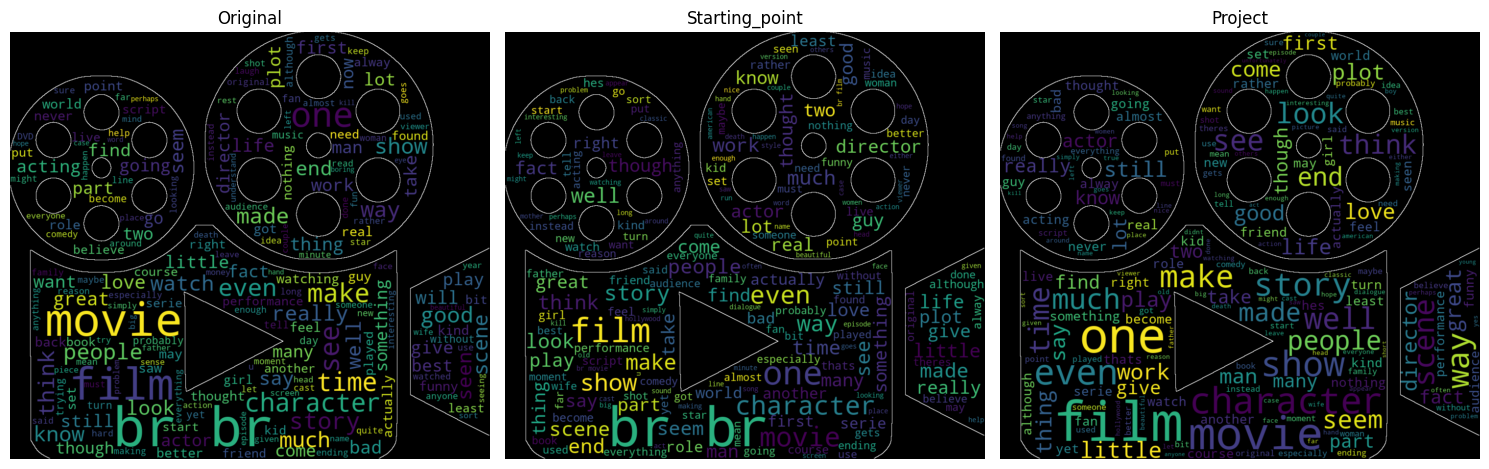

In [12]:
def comparar_nubes_de_palabras(nube1, nube2, nube3):
    """
    Crea y muestra una imagen comparativa de tres nubes de palabras.
    Parameters:
    - nube1, nube2, nube3: Objetos WordCloud
    Returns:
    None
    """
    # Obtener las matrices de las nubes de palabras
    array1 = nube1.to_array()
    array2 = nube2.to_array()
    array3 = nube3.to_array()

    # Crear subplots para cada nube de palabras
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Configurar el primer subplot
    axs[0].imshow(array1, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title('Original')

    # Configurar el segundo subplot
    axs[1].imshow(array2, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title('Starting_point')

    # Configurar el tercer subplot
    axs[2].imshow(array3, interpolation='bilinear')
    axs[2].axis('off')
    axs[2].set_title('Project')

    # Ajustar el diseño
    plt.tight_layout()

    # Mostrar la imagen comparativa
    plt.show()

    
comparar_nubes_de_palabras(ori, wc_point, wc_cleandf)

#### Diferencia entre las word Clouds:

Observando las distintas nubes de palabras, es evidente que las palabras más relevantes varían al aplicar la función de limpieza del punto de partida en comparación con la función del proyecto. Se notan discrepancias en relación con el conjunto de datos original. No obstante, al emplear la función de limpieza del punto de partida, podría sugerirse erróneamente que la palabra 'br' es la más relevante. ¿Es esto realmente así?

Para abordar este tipo de palabras sin significado, en la función de limpieza del proyecto la hemos diseñado para eliminar letras aisladas y palabras compuestas por solo dos letras. Aparentemente, nuestra función de limpieza es más meticulosa en este aspecto.

## Preprocesamiento Textual: Lematización y Derivación 

En el proceso de análisis de texto, es crucial abordar la variabilidad léxica y morfológica de las palabras. Con el objetivo de optimizar la representación de nuestro corpus, hemos implementado tanto la lematización como la derivación (stemming).

#### Lemmatización

Es el proceso que implica reducir las palabras a su forma base o lema, con el objetivo de agrupar las diferentes variaciones de una palabra y así poder tratarlas como una única entidad.

In [13]:
#función para lematizar el dataset, descompone las palabras para llegar a la raiz
def lemm(data):
    wordnet = WordNetLemmatizer()
    lemmanized = []
    for i in range(len(data)):
        lemmed = []
        words = word_tokenize(data['text'].iloc[i])
        for w in words:
            lemmed.append(wordnet.lemmatize(w))
        lemmanized.append(lemmed)

    data['lemmanized'] = lemmanized
    data['text'] = data['lemmanized'].apply(' '.join)
    data=data.drop("lemmanized",axis=1)
    return data

In [14]:
#Pendiente de hacer
#Realizar una prueba con este apartado
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Por defecto, asumir sustantivo

def lemmatize_words(word_list):
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    
    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(word_list)
    
    lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words]
    return lemmas

# Ejemplo de uso
palabras_no_lematizadas = ['running', 'jumped', 'swimming', 'cats', 'dogs', 'better', 'biggest', 'playing', 'developers', 'programming', 'flies']

# Obtener lemas
resultados = lemmatize_words(palabras_no_lematizadas)

# Mostrar resultados
for palabra, lema in zip(palabras_no_lematizadas, resultados):
    print(f'{palabra} -> {lema}')


[nltk_data] Downloading package wordnet to /Users/puigpi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/puigpi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


running -> run
jumped -> jump
swimming -> swim
cats -> cat
dogs -> dog
better -> good
biggest -> big
playing -> playing
developers -> developer
programming -> program
flies -> fly


#####  Obtenemos las versiones lematizadas de los conjuntos de datos de entrenamiento y prueba

In [15]:
train_lemm = lemm(df_train)
test_lemm = lemm(df_test)

In [16]:
train_lemm.head()

,text,label
0,grew watching loving thunderbird mate school w...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,die hard dad army fan nothing ever change got ...,1


### Derivación 

El stemming es el procedimiento que consiste en la eliminación de prefijos y sufijos de las palabras con el objetivo de llegar a la raíz. A diferencia de la lematización, busca reducir las palabras sin tener en cuenta su contexto gramatical.

In [17]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stemming_dataset(dataset):
    nltk.download('punkt')  # Descargar el tokenizador de palabras
    stemmer = PorterStemmer()
    dataset['text'] = dataset['text'].apply(lambda text: ' '.join([stemmer.stem(word) for word in word_tokenize(text)]))
    return dataset

#####  Obtenemos las versiones stemmizadas de los conjuntos de datos de entrenamiento y prueba

In [18]:
train_stem = stemming_dataset(df_train)
test_stem = stemming_dataset(df_test)

[nltk_data] Downloading package punkt to /Users/puigpi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/puigpi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
train_stem.head()

,text,label,lemmanized
0,grew watch love thunderbird mate school watch ...,0,"[grew, watching, loving, thunderbird, mate, sc..."
1,put movi dvd player sat coke chip expect hope ...,0,"[put, movie, dvd, player, sat, coke, chip, exp..."
2,peopl know particular time past like feel need...,0,"[people, know, particular, time, past, like, f..."
3,even though great interest biblic movi bore de...,0,"[even, though, great, interest, biblical, movi..."
4,die hard dad armi fan noth ever chang got tape...,1,"[die, hard, dad, army, fan, nothing, ever, cha..."


#### ¿Con cuál de estos dos procesos obtendremos mejores resultados? ¿Por qué?

#### Pipeline, Vectorización, TF-IDF, TRUNCATESVD (dataset Proyecto)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
'''

TfidfVectorizer combina la funcionalidad de CountVectorizer y TfidfTransformer en una sola clase. 

'''

# Crear el pipeline
text_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),     # crea una matriz de recuento y Transformar la matriz de recuento en una representación normalizada de frecuencias TF o TF-IDF
    ('lr', LogisticRegression()),      # Modelo de Regresión Logística
])


text_lr2 = Pipeline([
    ('tfidf', TfidfVectorizer()),      # crea una matriz de recuento y Transformar la matriz de recuento en una representación normalizada de frecuencias TF o TF-IDF
    ('svd', TruncatedSVD(n_components = 50)),  # TruncatedSVD para reducción de dimensionalidad
    ('lr', LogisticRegression()),      # Modelo de Regresión Logística
])

In [21]:
def extract_features_and_label(dataset):
    return dataset['text'], dataset['label']

#### Definimos el conjunto de datos después de aplicar la lematización y la derivación.

In [22]:
# Conjunto de datos aplicando lematización
X, y = extract_features_and_label(train_lemm)
X_test, y_test = extract_features_and_label(test_lemm)

In [23]:
# Conjunto de datos aplicando derivación
X_2, y_2 = extract_features_and_label(train_stem)
X_test_2, y_test_2 = extract_features_and_label(test_stem)

##### Primero ejecutaremos el pipeline con el conjunto de datos aplicando la lematización.

In [24]:
#ejecutamos el Pipeline sin el uso de TruncateSVD()
text_lr.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

In [25]:
y_pred = text_lr.predict(X_test)

In [26]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Imprimir las métricas
print(f'Precision: {precision}, Recall: {recall}, F1-score: {f1}, Accuracy: {accuracy}, Mean Squared Error (MSE): {mse}')

Precision: 0.8892828999211978, Recall: 0.900998003992016, F1-score: 0.8951021217529249, Accuracy: 0.8942, Mean Squared Error (MSE): 0.1058


* Precision: Representa la proporción de instancias positivas identificadas correctamente entre todas las instancias identificadas como positivas. Con una presición del 0.889 significa que alrededor del 89% de las instancias que el modelo identificó como positivas son realmente positivas

* Recall: Calcula la capacidad que tiene el modelo que predecir como positivos los que realmente son positivos, es decir que el 90% de las instancias fueron identificadas correctamente
por el modelo.

* F1-Score : Muestra el equilibrio entre el recall y precision, es útil cuando queremos tener en cuenta ambas métricas, se obtiene 89.5% de equilibrio.

* MSE: un MSE de 0.1058 indica que, en promedio, las predicciones difieren de los valores reales en alrededor del 10.58% del rango total.

 Estas métricas indican que el modelo tiene un rendimiento bastante bueno en la clasificación. La precisión y el recall son altos, y el F1-score refuerza la idea de que hay un buen equilibrio entre ambas métricas.

#### Pipeline + TruncateSVD

In [27]:
text_lr2.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=50)),
                ('lr', LogisticRegression())])

In [28]:
y_pred2 = text_lr2.predict(X_test)

In [29]:
precision2 = precision_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
f1_2 = f1_score(y_test, y_pred2)
accuracy2 = accuracy_score(y_test, y_pred2)
mse2 = mean_squared_error(y_test, y_pred2)

# Imprimir las métricas
print(f'Precision: {precision2}, Recall: {recall2}, F1-score: {f1_2}, Accuracy: {accuracy2}, Mean Squared Error (MSE): {mse2}')

Precision: 0.839458413926499, Recall: 0.8662674650698603, F1-score: 0.8526522593320236, Accuracy: 0.85, Mean Squared Error (MSE): 0.15


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_pipelines_mx(X, y, X_test, y_test, text_lr, text_lr2):
    ''' La función devuelve el DataFrame de resultados, así como las matrices de confusión
    asociadas a cada modelo, permitiendo una evaluación completa del rendimiento de los modelos
    con los diferentes pipelines '''
    
    # Ajustar los modelos
    text_lr.fit(X, y)
    text_lr2.fit(X, y)
    
    # Hacer predicciones en el conjunto de prueba
    y_pred = text_lr.predict(X_test)
    y_pred2 = text_lr2.predict(X_test)
    
    #Calcular matrix de confusion
    conf_matrix_lr = confusion_matrix(y_test, y_pred)
    conf_matrix_lr2 = confusion_matrix(y_test, y_pred2)
    
    # Calcular métricas para el primer modelo
    precision1 = precision_score(y_test, y_pred)
    recall1 = recall_score(y_test, y_pred)
    f11 = f1_score(y_test, y_pred)
    accuracy1 = accuracy_score(y_test, y_pred)
    mse1 = mean_squared_error(y_test, y_pred)

    # Calcular métricas para el segundo modelo
    precision2 = precision_score(y_test, y_pred2)
    recall2 = recall_score(y_test, y_pred2)
    f12 = f1_score(y_test, y_pred2)
    accuracy2 = accuracy_score(y_test, y_pred2)
    mse2 = mean_squared_error(y_test, y_pred2)

    # Crear un DataFrame con los resultados
    results = pd.DataFrame({
        'Modelo': ['Pipeline Simple', 'Pipeline con TruncateSVD'],
        'Precision': [precision1, precision2],
        'Recall': [recall1, recall2],
        'F1': [f11, f12],
        'Accuracy': [accuracy1, accuracy2],
        'MSE': [mse1, mse2]
    })

    # Imprimir el cuadro comparativo
    #print("Cuadro Comparativo: Pipeline Simple vs Pipeline con TruncateSVD")
    return results, conf_matrix_lr, conf_matrix_lr2

#### Evaluacion de Pipelines con modelo de Regresión Logistica

In [31]:
evaluacion, conf_matrix_lr, conf_matrix_lr2 = evaluate_pipelines_mx(X, y, X_test, y_test, text_lr, text_lr2)
evaluacion

,Modelo,Precision,Recall,F1,Accuracy,MSE
0,Pipeline Simple,0.889283,0.900998,0.895102,0.8942,0.1058
1,Pipeline con TruncateSVD,0.835537,0.857884,0.846563,0.8442,0.1558


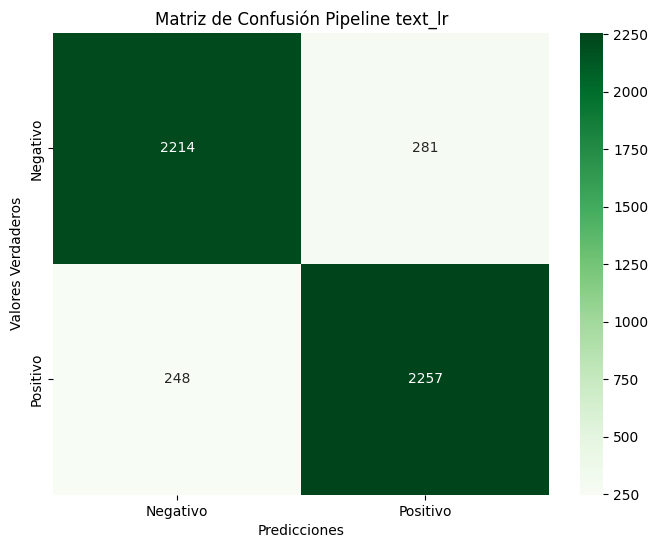

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Greens', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Pipeline text_lr')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

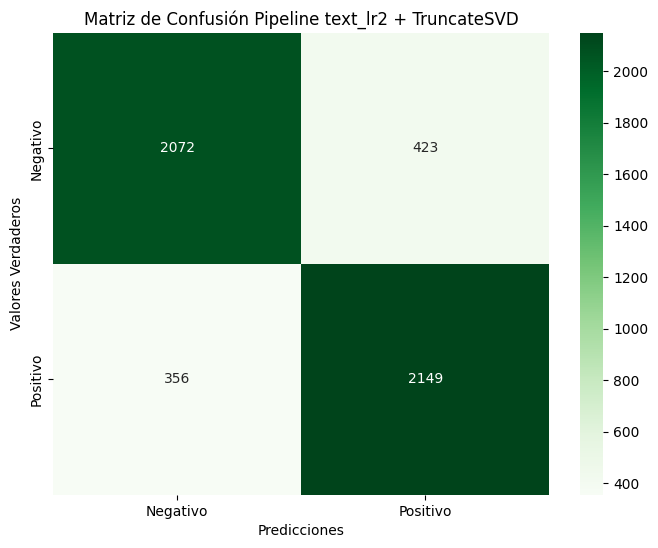

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr2, annot=True, fmt='d', cmap='Greens', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Pipeline text_lr2 + TruncateSVD')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

#### ¿Por qué cuando hacemos TruncateSVD al dataset el rendimiento del modelo disminuye? 

#### Ahora evaluaremos el rendimiento de los pipelines con el conjunto de datos después de aplicar la derivación

In [34]:
text_lr_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),     # crea una matriz de recuento y Transformar la matriz de recuento en una representación normalizada de frecuencias TF o TF-IDF
    ('lr', LogisticRegression()),      # Modelo de Regresión Logística
])


text_lr2_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),      # crea una matriz de recuento y Transformar la matriz de recuento en una representación normalizada de frecuencias TF o TF-IDF
    ('svd', TruncatedSVD(n_components = 50)),  # TruncatedSVD para reducción de dimensionalidad
    ('lr', LogisticRegression()),      # Modelo de Regresión Logística
])

##### Primero ejecutamos el pipeline en el que no aplicamos la reducción de dimensionalidad.

In [35]:
text_lr_2.fit(X_2, y_2)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

In [36]:
y_pred_lr_2 = text_lr_2.predict(X_test_2)

##### Ahora ejecutamos el segundo pipeline en el que agregamos TruncatedSVD.

In [37]:
text_lr2_2.fit(X_2, y_2)
y_pred_lr2_2 = text_lr2_2.predict(X_test_2)

In [38]:
evaluacion_2, conf_matrix_lr_2, conf_matrix_lr2_2 = evaluate_pipelines_mx(X_2, y_2, X_test_2, y_test_2, text_lr_2, text_lr2_2)
evaluacion_2

,Modelo,Precision,Recall,F1,Accuracy,MSE
0,Pipeline Simple,0.881548,0.900200,0.890776,0.8894,0.1106
1,Pipeline con TruncateSVD,0.839196,0.866667,0.852710,0.8500,0.1500


* Precision: La precisión del pipeline sin TruncatedSVD es más alta, lo que sugiere que es más efectivo para identificar instancias positivas entre todas las instancias identificadas como positivas, tal como indican sus valores (0.88 > 0.83).

* Recall: El recall del pipeline sin TruncatedSVD es más alto, indicando que captura un mayor porcentaje de instancias positivas reales en comparación con el pipeline con TruncatedSVD. Esto se refleja en sus valores, siendo (0.90 > 0.86).

* F1-Score: El F1-score del pipeline sin TruncatedSVD es más alto, lo que señala un mejor equilibrio entre precisión y recall en comparación con el pipeline con TruncatedSVD. Esto se refleja en sus valores, siendo (0.89 > 0.85).

* MSE: El MSE del pipeline sin TruncatedSVD es significativamente más bajo, indicando que las predicciones de este modelo difieren en menor cantidad en comparación con el pipeline con TruncatedSVD. Esto se refleja en sus valores, siendo (0.1106 < 0.1558).


Estas métricas indican que el Pipeline Simple tiene un rendimiento globlal mejor en estas categorías. 

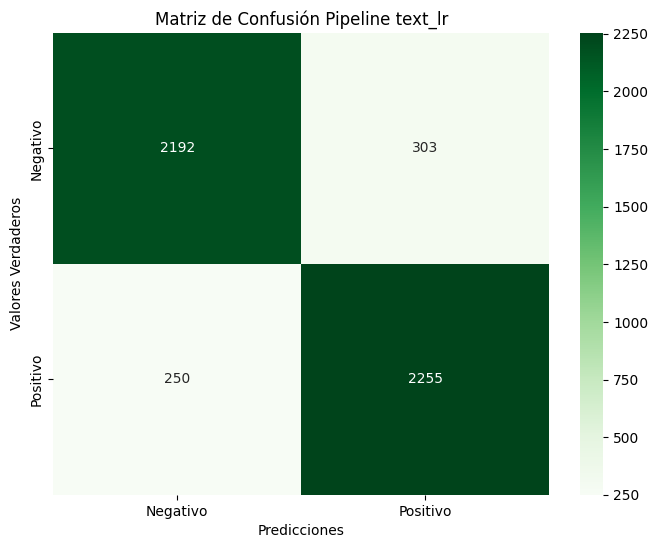

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr_2, annot=True, fmt='d', cmap='Greens', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Pipeline text_lr')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

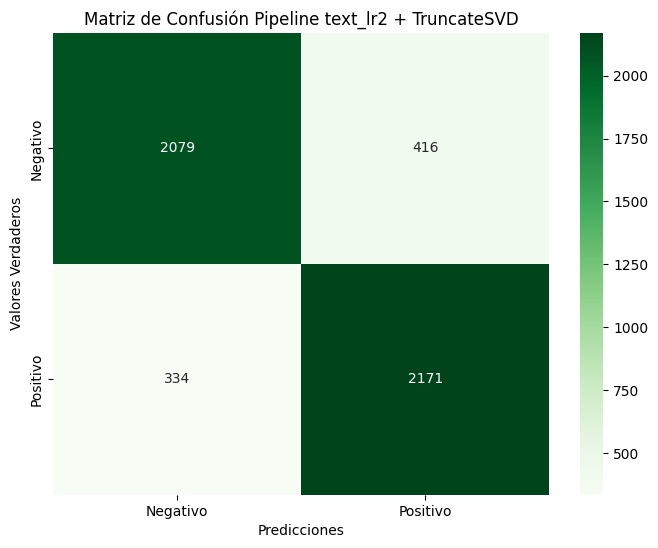

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr2_2, annot=True, fmt='d', cmap='Greens', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Pipeline text_lr2 + TruncateSVD')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

### Búsqueda de Hyperparámetros
##### En esta fase del proyecto, nos enfocaremos en la optimización de los hyperparámetros para cada uno de los modelos que estamos utilizando. Los hyperparámetros desempeñan un papel crucial en la configuración y el rendimiento de nuestros modelos de aprendizaje automático, y ajustarlos adecuadamente puede marcar la diferencia en términos de precisión y generalización.

### Búsqueda de Hyperparámetros para modelo de regresión logística.

### Para este modelo buscaremos los mejores hyperparámetros para los siguientes parámetros:

- penalty: Especifica el tipo de penalización que se aplicará durante la optimización del modelo.
  Espació de búsqueda: ['l1', 'l2']
- C: Es el inverso del parámetro de regularización.
  Espació de búsqueda:  [0.001, 0.01, 0.1, 1, 10, 100, 1000]
- Solver: Especifica el algoritmo de optimización a utilizar para resolver el problema de optimización asociado con la regresión logística.
  Espació de búsqueda: ['newton-cg', 'lbfgs', 'liblinear']
- max_iter: Es el número máximo de iteraciones permitidas durante la optimización.
  Espació de búsqueda:  [50, 100, 300]


In [47]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'penalty': ['l1', 'l2'],                   # Tipo de penalización
    'C': [0.001, 0.01, 0.1, 1, 10,100, 1000],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],  # Algoritmo de optimización
    'max_iter': [50, 100, 300],            # Número máximo de iteraciones
}
tfid = TfidfVectorizer()
x_train = tfid.fit_transform(X)
x_test = tfid.transform(X_test)

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5,n_jobs=-1, scoring='accuracy')
grid_search.fit(x_train, df_train['label'])
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sc

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.893


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Búsqueda de Hyperparámetros para un modelo SVC.

### Para este modelo buscaremos los mejores hyperparámetros para los siguientes parámetros:

- C: Es el inverso del parámetro de regularización.
  Espació de búsqueda:  [0.001, 0.01, 0.1, 1, 10, 100, 1000]
- kernel: Especifica el tipo de kernel a utilizar.
  Espació de búsqueda:  [linear, rbf, poly]
- gama: Coeficiente del kernel (para 'rbf')
  Espació de búsqueda: [scale, auto]
- degree: Grado del polinomio (para 'poly')
  Espació de búsqueda:  [2, 3, 4]
  

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)


# Ajustar el modelo a los datos de entrenamiento con búsqueda aleatoria
#best_model = random_search.best_params_

grid_search.fit(x_train, y)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores Hyperparámetros:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 7.9min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 7.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 7.9min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 7.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 7.9min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 7.9min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.4min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.4min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=10.4min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=11.9min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=12.0min
[CV] END ......................C=0.1, gamma=auto,

In [43]:
print("Best Score:", grid_search.best_score_)

Best Score: 0.8932999423680658
